In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [53]:
def Sliding_Window(df_temp,win_len,stride):
    X=[]
    Y=[]
    T=[]

    for i in np.arange(0,len(df_temp)-(win_len),stride):
        temp = df_temp.iloc[i:i+win_len,[3,4]].values

        X.append(temp)
        Y.append(df_temp.iloc[i+win_len,-1])
        T.append(df_temp.iloc[i+win_len,0])

    return np.array(X),np.array(Y),np.array(T)

- The data imported from the Matlab-simulink model are in **csv format**, with name as "{Fault}_noise_02.csv"
- **M** number of such files are present, coresponding to **M** faults.
- In each fault file, the fault is introduced at **t=\[1000,1500\]s** for incipient fault and **t=\[2000,2500\]s** for the step fault.

The Goal is to extract only the values of residuals between t=\[1000,1500\]s and t=\[2000,2500\]s. These values are then stored in a **new DataFrame**, which contains the residual information for all the fault classes. 

In [55]:
working_cond = 40

Path = r'.\ALL_DC_motor_Data\Ua_{}V_Noise_2_perct'.format(working_cond) # Path of the folder containing CSV files from that working condition
file_name = os.listdir(path=Path) 

In [57]:
def PreprocessData(working_cond,win_len,stride):
    Path = r'.\ALL_DC_motor_Data\Ua_{}V_Noise_2_perct'.format(working_cond) # Path of the folder containing CSV files from that working condition
    file_name = os.listdir(path=Path) 


    X_full, Y_full = [], []

    for f in file_name : #Iterate through each file, which coresponds to a Fault
        csv_path =  os.path.join(Path,f)
        df = pd.read_csv(csv_path)

        temp_df_1=df[(df.time > 1050) & (df.time< 1500)]  # Incipient-Taking samples after which the Parameter fault was introduced

        x1, y1, _ = Sliding_Window(temp_df_1,win_len,stride)

        temp_df_2=df[(df.time > 2050) & (df.time< 2500)]  # Step -Taking samples after which the Parameter fault was introduced

        x2, y2, _ = Sliding_Window(temp_df_2,win_len,stride)

        x_temp, y_temp = np.concatenate((x1,x2),axis=0),np.concatenate((y1,y2),axis=0)

        X_full.append(x_temp)
        Y_full.append(y_temp)


    X_full = np.array(X_full)
    X_full = np.reshape(X_full, (-1,X_full.shape[2],X_full.shape[3]))

    Y_full = np.array(Y_full)
    Y_full = np.reshape(Y_full, (-1))

    return X_full, Y_full


In [58]:
WL=20
S=40

X_120, Y_120 = PreprocessData(working_cond=120,win_len=WL,stride=S)
X_80, Y_80  = PreprocessData(working_cond=80,win_len=WL,stride=S)
X_40, Y_40 = PreprocessData(working_cond=40,win_len=WL,stride=S)

In [59]:
X_full = np.concatenate((X_40,X_80,X_120))
Y_full = np.concatenate((Y_40,Y_80,Y_120))

print(f"length of total data = {len(X_full)}")

length of total data = 5376


In [93]:
# Train Test split
X_train, X_test, y_train, y_test = train_test_split(X_full, Y_full, train_size=200, random_state=42)

# Standardising the data
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train.reshape(-1,X_train.shape[-1])).reshape(X_train.shape)
X_test_sc = scaler.transform(X_test.reshape(-1,X_test.shape[-1])).reshape(X_test.shape)
# One Hot encoding
encoder = OneHotEncoder(sparse=False)
y_train_ohe = encoder.fit_transform(y_train.reshape(-1,1))
y_test_ohe = encoder.transform(y_test.reshape(-1,1))

# CNN Model

In [95]:
def CNN_model(encoder,X_train_transformed):
    from tensorflow.keras.models import Sequential,Model
    from tensorflow.keras.layers import Input,Dense, Dropout, Flatten
    from tensorflow.keras.layers import Conv1D, MaxPooling1D

    num_classes=len(encoder.categories_[0])

    cnn_model = Sequential()
    cnn_model.add(Conv1D(32, kernel_size=(3),activation='relu',input_shape=(X_train_transformed.shape[1],X_train_transformed.shape[2]),padding='same'))
    cnn_model.add(MaxPooling1D((2),padding='same'))
    cnn_model.add(Flatten())
    cnn_model.add(Dense(128, activation='relu'))
    cnn_model.add(Dense(num_classes, activation='sigmoid'))

    cnn_model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
    
    return cnn_model

# AI Training

In [96]:
from sklearn.metrics import f1_score
import tensorflow

callback = tensorflow.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10,restore_best_weights=True)

cnn_model=CNN_model(encoder,X_train_sc)

In [98]:
cnn_model.fit(X_train_sc,
            y_train_ohe,
            epochs=200,
            batch_size=32,              
            validation_data=(X_test_sc, y_test_ohe),
            callbacks=[callback],
            shuffle=False,verbose=1)

Epoch 1/200
7/7 [==============================] - 3s 386ms/step - loss: 0.0546 - accuracy: 0.9900 - val_loss: 0.0584 - val_accuracy: 0.9772
Epoch 2/200
7/7 [==============================] - 2s 373ms/step - loss: 0.0518 - accuracy: 0.9900 - val_loss: 0.0554 - val_accuracy: 0.9764
Epoch 3/200
7/7 [==============================] - 2s 285ms/step - loss: 0.0491 - accuracy: 0.9850 - val_loss: 0.0527 - val_accuracy: 0.9755
Epoch 4/200
7/7 [==============================] - 2s 313ms/step - loss: 0.0464 - accuracy: 0.9850 - val_loss: 0.0502 - val_accuracy: 0.9733
Epoch 5/200
7/7 [==============================] - 2s 284ms/step - loss: 0.0439 - accuracy: 0.9850 - val_loss: 0.0480 - val_accuracy: 0.9728
Epoch 6/200
7/7 [==============================] - 2s 299ms/step - loss: 0.0417 - accuracy: 0.9850 - val_loss: 0.0459 - val_accuracy: 0.9726
Epoch 7/200
7/7 [==============================] - 2s 279ms/step - loss: 0.0397 - accuracy: 0.9850 - val_loss: 0.0439 - val_accuracy: 0.9731
Epoch 8/200
7

In [99]:
y_pred=cnn_model.predict(X_test_sc)
y_pred=encoder.inverse_transform(y_pred)

print(f"Train Sample = {len(X_train)} , The F1 score is- {f1_score(y_test,y_pred,average='weighted')}")


Train Sample = 200 , The F1 score is- 0.9779681509435696


# Real Time Fault Diagnosis

In [100]:
fault_label_dict = {'Healthy':0, 'I':3, 'I & W':7, 'K':5, 'Re':1, 'Re & Rm':6, 'Rm':2, 'W':4}

In [101]:
def Predict_CNN(fault_file, cnn_model, scaler, encoder, WL, S):
    '''fault_file = 'Healthy_noise_02.csv',
    'I & W_noise_02.csv',
    'I_noise_02.csv',
    'K_noise_02.csv',
    'Re & Rm_noise_02.csv',
    'Re_noise_02.csv',
    'Rm_noise_02.csv',
    'W_noise_02.csv'''
    csv_path =  os.path.join(Path,fault_file)
    df = pd.read_csv(csv_path)
    x1, y1, t1 = Sliding_Window(df,win_len=WL,stride=S)
    x_sc = scaler.transform(x1.reshape(-1,x1.shape[-1])).reshape(x1.shape)

    y_pred=cnn_model.predict(x_sc)
    y_pred=encoder.inverse_transform(y_pred)

    y_pred_num = np.vectorize(fault_label_dict.get)(y_pred)
    y_pred_num = y_pred_num.reshape(-1) 


    y_true_num = np.vectorize(fault_label_dict.get)(y1)
    y_true_num = y_true_num.reshape(-1) 

    return y_pred_num,y_true_num,t1

In [102]:
def plot_online_FDI(y_pred_num,y_true_num,t1):
    plt.subplots(figsize=(8,3))

    sns.scatterplot(x=t1,y=y_pred_num,hue=y_true_num,palette="bright",edgecolor='black',alpha=0.5,s=30)

    # Add labels and title
    plt.xlabel('time (s)',fontsize=10)
    plt.ylabel('Predicted fault class',fontsize=10)

    plt.yticks([0,1,2,3,4,5,6,7])
    plt.ylim([-.5,7.5])
    # ax.set_title('Line Plot of Dataset Size vs. Win Length')
    plt.legend(markerscale=1.5,bbox_to_anchor=(1.01, 1.05),title='Actual fault class',fontsize=10)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.axvspan(xmin=1000, xmax=1500, facecolor='r', alpha=0.2)
    plt.axvspan(xmin=2000, xmax=2500, facecolor='r', alpha=0.2)
    # Display the plot
    plt.show()

Introduced fault is Healthy


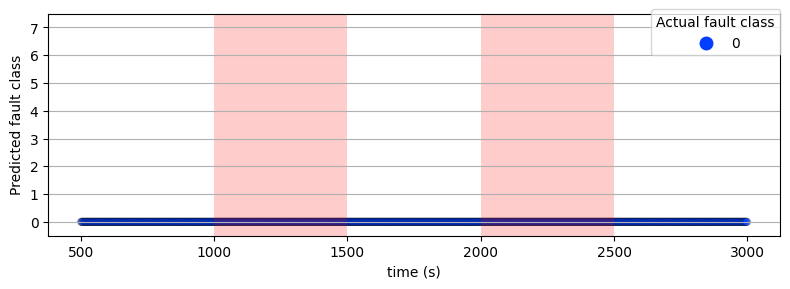

Introduced fault is I & W


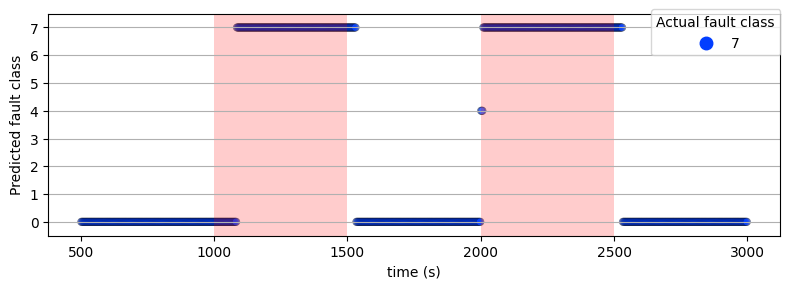

Introduced fault is I


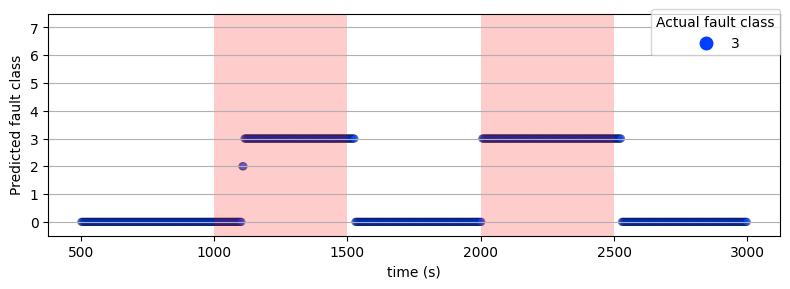

Introduced fault is K


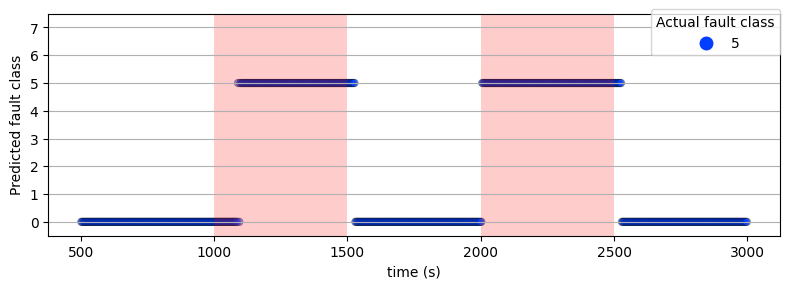

Introduced fault is Re & Rm


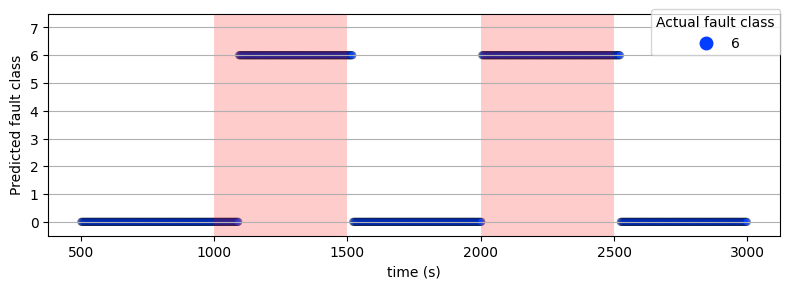

Introduced fault is Re


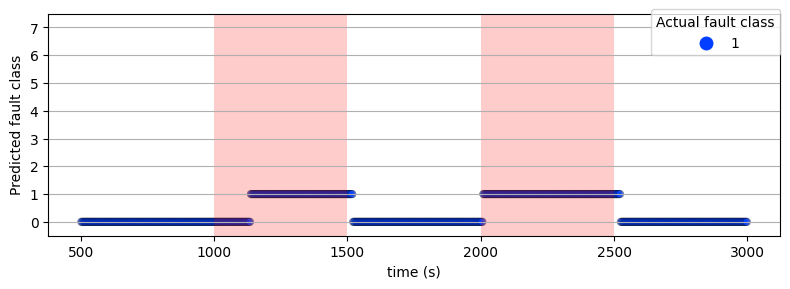

Introduced fault is Rm


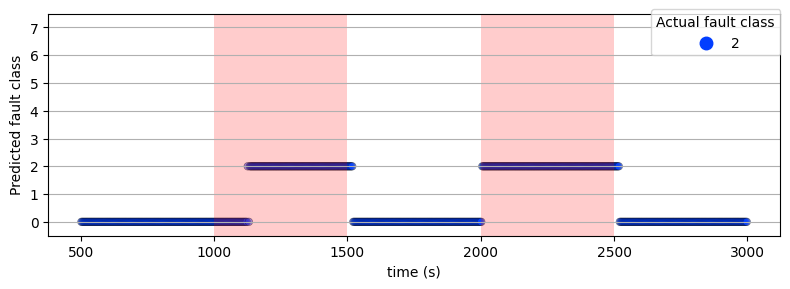

Introduced fault is W


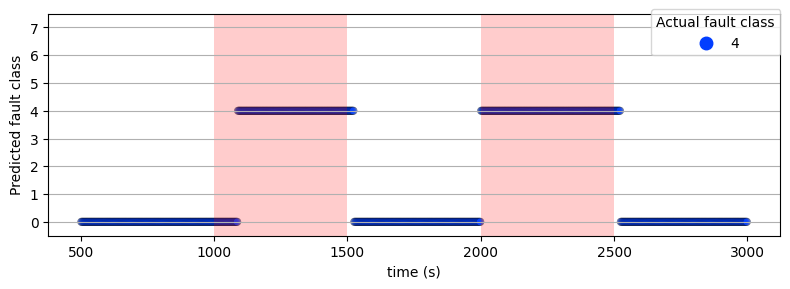

In [103]:
for f in file_name:
    print(f"Introduced fault is {f[:-13]}")
    y_pred_num,y_true_num,t1 = Predict_CNN(fault_file=f, cnn_model=cnn_model, scaler=scaler, encoder=encoder, WL=WL, S=S)
    plot_online_FDI(y_pred_num,y_true_num,t1)